<h2>Pick and Place with Vision</h2>

<br>Richiede 'sim.py', 'simConst.py', 'remoteapi.dll' all'interno della stessa cartella del notebook jupyter.</br> 
<br> La scena implementata per CoppeliaSim è: VisioCoSM_2.ttt</br> 


In [475]:
# Importiamo le librerie necessarie
import sim          # libreria per connettersi con CoppeliaSim
import sympy as sp  # libreria per il calcolo simbolico
import time
import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
import numpy as np 

In [476]:
def connect(port):
#Stabilire una connessione a VREP
#la porta deve corrispondere alla porta di connessione in VREP
#restituisce il numero del client o -1 se non riesce a stabilire una connessione
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Connection
    if clientID == 0: print("connected to", port)
    else: print("Could not connect")
    return clientID


In [477]:
def setEffector(val):
# Azionare l'end-effector
# val è un Int con valore 0 o 1 per disabilitare o abilitare l'attuatore finale.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

In [478]:
# Abbiamo bisogno delle "handle" per le articolazioni e il manipulator
clientID = connect(19999)

retCode,effector=sim.simxGetObjectHandle(clientID,'effector',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'MTB_joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'MTB_joint2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'MTB_joint3',sim.simx_opmode_blocking)
retCode,joint4=sim.simxGetObjectHandle(clientID,'MTB_joint4',sim.simx_opmode_blocking)
retCode,cuboRosso=sim.simxGetObjectHandle(clientID,'CuboRosso',sim.simx_opmode_blocking)
retCode,cuboBlu=sim.simxGetObjectHandle(clientID,'CuboBlu',sim.simx_opmode_blocking)

print(effector, joint1, joint2, joint3, joint4, cuboRosso, cuboBlu)

connected to 19999
33 17 20 23 26 35 36


In [479]:
# Inviamo le posizioni alle articolazioni
q = [0, 0, 0.0]

retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)


In [480]:
# Attiviamo o disattiviamo l'attuatore finale
setEffector(0)

0

###  1. Prepariamo le informazioni necessarie
Dalla matrice della cinematica diretta calcoliamo la cinematica inversa.

In [481]:
# 1. Espressioni della cinematica diretta

q1 = sp.symbols('q1') # angolo dell'articolazione rotazionale joint1, in radianti
q2 = sp.symbols('q2') # angolo dell'articolazione rotazionale joint2, in radianti
q3 = sp.symbols('q3') # posizione dell'articolazione prismatica joint3, in metri
q4 = sp.symbols('q4') # angolo dell'articolazione rotazionale joint4, in radianti

T = sp.Matrix([[sp.cos(q1 + q2 + q4), -sp.sin(q1 + q2 + q4), 0, 0.467*sp.cos(q1) + 0.4005*sp.cos(q1 + q2)],
            [sp.sin(q1 + q2 + q4), sp.cos(q1 + q2 + q4), 0, 0.467*sp.sin(q1) + 0.4005*sp.sin(q1 + q2)], 
            [0, 0, 1, 0.234 - q3], 
            [0, 0, 0, 1]])
T

Matrix([
[cos(q1 + q2 + q4), -sin(q1 + q2 + q4), 0, 0.467*cos(q1) + 0.4005*cos(q1 + q2)],
[sin(q1 + q2 + q4),  cos(q1 + q2 + q4), 0, 0.467*sin(q1) + 0.4005*sin(q1 + q2)],
[                0,                  0, 1,                          0.234 - q3],
[                0,                  0, 0,                                   1]])

###  2. Otteniamo la posizione del punto di destinazione


In [482]:
def matrixFromPose(pose):
    # pose = [x, y, z, alpha, beta, gamma]
    # x, y, z en metros
    # alpha, beta, gamma en radianes
    x, y, z = pose[0], pose[1], pose[2]
    alpha, beta, gamma = pose[3], pose[4], pose[5]
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    T[0,3] = x
    T[1,3] = y
    T[2,3] = z
    return T

# Definiamo una funzione per costruire la matrice di rotazione
# Partendo dagli angoli di Eulero

def matrixFromEuler(alpha, beta, gamma):
    # theta y alpha en radianes
    # d y a en metros
    Ra = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    Rb = sp.Matrix([[sp.cos(beta), 0, sp.sin(beta), 0],
                   [0, 1, 0, 0],
                   [-sp.sin(beta), 0, sp.cos(beta), 0],
                   [0, 0, 0, 1]])
    Rc = sp.Matrix([[sp.cos(gamma), -sp.sin(gamma), 0, 0],
                   [sp.sin(gamma), sp.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    T = Ra*Rb*Rc
    return T

# Connettiti al server e ottieni handle
def getHandlers():
    retCode,effector=sim.simxGetObjectHandle(clientID,'effector',sim.simx_opmode_blocking)
    retCode,target=sim.simxGetObjectHandle(clientID,'CuboRosso',sim.simx_opmode_blocking)
    retCode,joint1=sim.simxGetObjectHandle(clientID,'MTB_joint1',sim.simx_opmode_blocking)
    retCode,joint2=sim.simxGetObjectHandle(clientID,'MTB_joint2',sim.simx_opmode_blocking)
    retCode,joint3=sim.simxGetObjectHandle(clientID,'MTB_joint3',sim.simx_opmode_blocking)
    retCode,joint4=sim.simxGetObjectHandle(clientID,'MTB_joint4',sim.simx_opmode_blocking)
    joint = [joint1, joint2, joint3, joint4]
    return joint, effector, target

In [483]:
matrixFromEuler(45*sp.pi/180, 0, 45*sp.pi/180)

Matrix([
[sqrt(2)/2, -sqrt(2)/2,          0, 0],
[      1/2,        1/2, -sqrt(2)/2, 0],
[      1/2,        1/2,  sqrt(2)/2, 0],
[        0,          0,          0, 1]])

In [484]:
#  A partire dalle coordinate della posizione e gli angoli di Eulero otteniamo 
#  la matrice di trasformazione

x = 0.0
y = 0.0
z = 0.0
alpha = 0
beta = 0
gamma = 45*sp.pi/180

t = sp.Matrix([[1, 0, 0, x],
               [0, 1, 0, y], 
               [0, 0, 1, z], 
               [0, 0, 0, 1]])

D = t*matrixFromEuler(alpha, beta, gamma)
D


Matrix([
[sqrt(2)/2, -sqrt(2)/2, 0, 0],
[sqrt(2)/2,  sqrt(2)/2, 0, 0],
[        0,          0, 1, 0],
[        0,          0, 0, 1]])

###  3. Calcoliamo la cinematica inversa


In [485]:
# Cerchiamo una soluzione diminuendo la precisione per facilitare il calcolo.
# Normalmente sarebbe a 15 cifre significative

try:
    q = sp.nsolve((T-D), (q1, q2, q3, q4), (1, 1, 1, 1), prec=6)
except:
    print('Could not find a solution')
    q = [0, 0, 0, 0]
q


Could not find a solution


[0, 0, 0, 0]

In [486]:
# verifichiamo la posizione dell'attuatore

retCode,pos=sim.simxGetObjectPosition(clientID, effector, -1, sim.simx_opmode_blocking)
print(pos)


[0.8671364784240723, 0.0217420756816864, 0.23351530730724335]


In [487]:
# La funzione nsolve di sympy cerca valori che eguagliano a zero l'espressione.
# Se vogliamo T=D, cerchiamo T-D = 0

T-D


Matrix([
[cos(q1 + q2 + q4) - sqrt(2)/2, -sin(q1 + q2 + q4) + sqrt(2)/2, 0, 0.467*cos(q1) + 0.4005*cos(q1 + q2)],
[sin(q1 + q2 + q4) - sqrt(2)/2,  cos(q1 + q2 + q4) - sqrt(2)/2, 0, 0.467*sin(q1) + 0.4005*sin(q1 + q2)],
[                            0,                              0, 0,                          0.234 - q3],
[                            0,                              0, 0,                                   0]])

In [488]:
# e l'orientamento

retCode,eul=sim.simxGetObjectOrientation(clientID, effector, -1, sim.simx_opmode_blocking)
print(eul[0]*180/3.1416)
print(eul[1]*180/3.1416)
print(eul[2]*180/3.1416)


-0.11509719622770369
0.020918684409123065
-29.89610180406738


In [489]:
retCode,sensorHandle=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
retCode, resolution, img=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
res, posizioneEffector = sim.simxGetObjectPosition(clientID, effector, -1, sim.simx_opmode_blocking)
retCode,sensorHandle2=sim.simxGetObjectHandle(clientID,'Vision_sensor2',sim.simx_opmode_blocking)
res, posizioneCamera = sim.simxGetObjectPosition(clientID, sensorHandle, -1, sim.simx_opmode_blocking)
res, posizioneCamera2 = sim.simxGetObjectPosition(clientID, sensorHandle2, -1, sim.simx_opmode_blocking)

###  2. Metodi per people tracking and detection, path planning e path avoidance

In [490]:
def personTracking():
    retCode, resolution2, img=sim.simxGetVisionSensorImage(clientID,sensorHandle2,0,sim.simx_opmode_oneshot_wait)
    image = np.array(img, dtype=np.uint8)
    image.resize([resolution2[1],resolution2[0],3])
    frame1 = image
    #time.sleep(0.05)
    retCode, resolution2, img=sim.simxGetVisionSensorImage(clientID,sensorHandle2,0,sim.simx_opmode_oneshot_wait)
    image = np.array(img, dtype=np.uint8)
    image.resize([resolution2[1],resolution2[0],3])
    frame2 = image
    
    diff = cv2.absdiff(frame1, frame2)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, None, iterations=3)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    position = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) < 500:
            continue
        #cv2.rectangle(frame1, (x, y), (x+w, y+h), (0, 255, 0), 2)
        #cv2.putText(frame1, "Status: {}".format('Movement'), (100, 100), cv2.FONT_HERSHEY_SIMPLEX,
        #            3, (0, 0, 255), 3)
        #print("x:" + str(x))
        #print("y:" + str(y))
        immXdiff = ((resolution2[0]/2) - x) * 0.01
        immYdiff = ((resolution2[1]/2) - y) * 0.01
        posizioneTarget=[0,0]
        posizioneTarget[0]=posizioneCamera2[0] + immXdiff
        posizioneTarget[1]=posizioneCamera2[1] + immYdiff
        position.append(posizioneTarget)
    #print("posizioni")
    #print(position)
    #plt.imshow(frame1)
    #plt.show()
    if len(position) != 0:
        return position[0]
    return position
#personTracking()

In [491]:
def path_planning(centers):
    #print("-------Path planning-----------")
    #print("posizione effector" + str(posizioneEffector))
    #print("Centri")
    #print(centers)
    tups = []
    for c in centers:
        dist = np.linalg.norm(np.array(posizioneEffector[0:2]) - np.array(c[0:2]))
        tups.append((c,dist))
    #print("tuple")
    #print(tups)    
    tups.sort(key = lambda x: x[1])
    #print("tuple ordinate")
    #print(tups)
    result = [tup[0] for tup in tups]
    #print("result")
    #print(result)
    return result

In [492]:
def path_avoidance(centers, personPosition):
    print("-------Path avoidance-----------")
    #print("posizione effector" + str(personPosition))
    #print("Centri")
    #print(centers)
    tups = []
    for c in centers:
        dist = np.linalg.norm(np.array(personPosition[0:2]) - np.array(c[0:2]))
        tups.append((c,dist))
    #print("tuple")
    #print(tups)    
    tups.sort(key = lambda x: x[1], reverse = True)
    #print("tuple ordinate")
    #print(tups)
    result = [tup[0] for tup in tups]
    #print("result")
    #print(result)
    return result
    


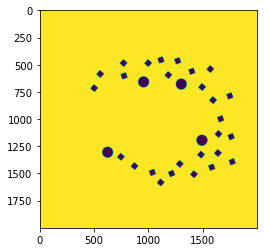

--> Acquisito ed elaborato l'immagine
numero di contorni: 32
numero centri: 27
-------- Centri elaborari --------


In [493]:
while(True):
    # Otteniamo l'immagine
    retCode, resolution, img=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
    image = np.array(img, dtype=np.uint8)
    image.resize([resolution[1],resolution[0],3])
    original_image= image
    
    #print(resolution)
    #cv2.imshow('image', img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #plt.imshow(image)
    #plt.show()

    #convert image into greyscale mode
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #find threshold of the image
    _, thrash = cv2.threshold(gray_image, 100, 190, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    plt.imshow(thrash)
    plt.show()
    
    centers=[]
    colori=[]
    print("--> Acquisito ed elaborato l'immagine")
    print("numero di contorni: " + str(len(contours)))
    
    for contour in contours:
        #print("...Elaboro contorni...")
        shape = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
        if shape[0][0][0] != 0:
            x_cor = shape.ravel()[0]
            y_cor = shape.ravel()[1]
            
            if len(shape) ==4:
                #shape cordinates
                x,y,w,h = cv2.boundingRect(shape)

                #width:height
                aspectRatio = float(w)/h
                #cv2.drawContours(image, [shape], 0, (0,255,0), 4)
                if aspectRatio >= 0.9 and aspectRatio <=1.1:
                    cv2.putText(image, "Square", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
                    M = cv2.moments(contour)
                    if M['m00'] != 0:
                        cx = int(M['m10']/M['m00'])
                        cy = int(M['m01']/M['m00'])
                        (b, g, r) = original_image[cy,cx]
                        colori.append([b, g, r])
                        #cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
                        #cv2.circle(image, (cx, cy), 7, (0, 255, 255), -1)
                        #cv2.putText(image, "center", (cx - 20, cy - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
                        centers.append([cx,cy])
                #else:
                    #cv2.putText(image, "Not a square", (x_cor, y_cor), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0))

        """    M = cv2.moments(contour)
          if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                retCode, resolution, img2=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
                image2 = np.array(img2, dtype=np.uint8)
                image2.resize([resolution[1],resolution[0],3])
                (b, g, r) = image2[cy,cx]
                colori.append([b, g, r])
                cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
                cv2.circle(image, (cx, cy), 7, (0, 255, 255), -1)
                cv2.putText(image, "center", (cx - 20, cy - 20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

            print(f"x: {cx} y: {cy}")
    """  


    """
    print("contorni elaborati")
    plt.imshow(image)
    plt.show()
    print(centers)
    print(colori)
    print("RED GREEN BLU")
    """
    
    # Notes on operative modes:
    # Blocking mode: The command is sent, and the function will wait for the actual reply and return it (if the function doesn't time out). 
    # The received command reply will be removed from the inbox buffer (other operation modes will leave their command replies in the inbox buffer).
    
    """
    ### COSE PER VEDERE SE IL PASSAGGIO TRA COORDINATE CAMERA E MONDO FUNZIONA
    # Otteniamo handle della camera e le coordinate
    retCode,camera=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
    res, posizioneCamera = sim.simxGetObjectPosition(clientID, camera, -1, sim.simx_opmode_blocking)
    print("POSIZIONE CAMERA")
    print(posizioneCamera)
    res, posizioneCuboRosso = sim.simxGetObjectPosition(clientID, cuboRosso, -1, sim.simx_opmode_blocking)
    print("POSIZIONE CUBO ROSSO")
    print(posizioneCuboRosso)
    xdiff = posizioneCamera[0] - posizioneCuboRosso[0]
    ydiff = posizioneCamera[1] - posizioneCuboRosso[1]
    print("diff from camera to target")
    print(xdiff, ydiff)
    """
    m = 0
    targets_rossi = []
    targets_blu = []
    sleep_time = 0.9
    #print("Centri")
    #print(centers)
    print("numero centri: " + str(len(centers)))
    for c in centers:
        if colori[m][0]>200:
            """
            Se il cubo è rosso RGB--> R>200
            In pratica prendo la risoluzione dell'immagine e la divido per 2 in modo
            che sono sulla coordinata centrale, dopo sottraggo la coordinata X del 
            centro del primo cubo e moltiplico per 0.001 per passare da pixel a 
            millimetri perché avendo impostato io l'unità di misura ho fatto in modo
            che 1 pixel coprisse 1 millimetro nel mondo reale... Quindi immXdiff é 
            la differenza tra coordinata X del centro della camera e coordinata X 
            del centro del cubo... Sommata questa differenza alla posizione della 
            camera che é nota si trova la posizione target
            """
            immXdiff = ((resolution[0]/2) - c[0]) * 0.001
            immYdiff = ((resolution[1]/2) - c[1]) * 0.001
            #print("diff calculated from the image")
            #print(immXdiff)
            #print(immYdiff)
            posizioneTarget=[0,0,0]
            posizioneTarget[0]=posizioneCamera[0] + immXdiff
            posizioneTarget[1]=posizioneCamera[1] + immYdiff
            posizioneTarget[2]=0.05
            eulC=[0,0,0]
            targetP = posizioneTarget + eulC
            #print(targetP)
            targets_rossi.append(targetP)
        else:
            immXdiff = ((resolution[0]/2) - c[0]) * 0.001
            immYdiff = ((resolution[1]/2) - c[1]) * 0.001
            #print("diff calculated from the image")
            #print(immXdiff)
            #print(immYdiff)
            posizioneTarget=[0,0,0]
            posizioneTarget[0]=posizioneCamera[0] + immXdiff
            posizioneTarget[1]=posizioneCamera[1] + immYdiff
            posizioneTarget[2]=0.05
            eulC=[0,0,0]
            targetP = posizioneTarget + eulC
            #print(targetP) 
            targets_blu.append(targetP)
        m=m+1
    break
print("-------- Centri elaborari --------")
    
  
   

In [494]:
targets_rossi = path_planning(targets_rossi)
targets_blu = path_planning(targets_blu)

In [495]:
while len(targets_rossi) != 0:
    
    personPosition = personTracking()
    print("result of person position: " + str(personPosition))
    if len(personPosition) != 0:
        targets_rossi = path_avoidance(targets_rossi, personPosition)
    
    sq = sp.symbols(['q1','q2','q3','q4'])
    T2 = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
    [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
    [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])

    # inviamo alla posa di destinazione
    d2 = targets_rossi[0]
    D2 = matrixFromPose(d2)
    q = sp.nsolve(T2-D2, sq, [0.1, 0.1, 0.1, 0.1], prec=6)
    #print('q')
    #print(q)
    # spostiamo il robot nella posizione
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint4, q[3], sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # abbassiamo l'attuatore
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # attiviamo l'end effector
    setEffector(1)
    time.sleep(sleep_time)
    # alziamo l'attuatore
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # andiamo alla posizione per i cubi rossi
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0.75, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # Disattiviamo l'attuatore
    time.sleep(sleep_time)
    setEffector(0)
    targets_rossi.remove(targets_rossi[0])
    print("Ne rimangono: " + str(len(targets_rossi)))
    #print(targets_rossi)
    #print("R-ok")

while len(targets_blu) != 0:
    
    personPosition = personTracking()
    if len(personPosition) != 0:
        targets_blu = path_avoidance(targets_blu, personPosition)
    
    sq = sp.symbols(['q1','q2','q3','q4'])
    T2 = sp.Matrix([[sp.cos(sq[0] + sq[1] + sq[3]), -sp.sin(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.cos(sq[0]) + 0.4005*sp.cos(sq[0] + sq[1])], 
    [sp.sin(sq[0] + sq[1] + sq[3]), sp.cos(sq[0] + sq[1] + sq[3]), 0, 0.467*sp.sin(sq[0]) + 0.4005*sp.sin(sq[0]+ sq[1])], 
    [0, 0, 1, 0.234 - sq[2]], [0, 0, 0, 1]])
    # inviamo alla posa di destinazione
    d2 = targets_blu[0]
    D2 = matrixFromPose(d2)
    q = sp.nsolve(T2-D2, sq, [0.1, 0.1, 0.1, 0.1], prec=6)
    #print('q')
    #print(q)
    # spostiamo il robot nella posizione
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint4, q[3], sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # abbassiamo l'attuatore
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # attiviamo l'end effector
    setEffector(1)
    time.sleep(sleep_time)
    # alziamo l'attuatore
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # andiamo alla posizione per i cubi blu
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, 0, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_blocking)
    time.sleep(sleep_time)
    # Disattiviamo l'attuatore
    time.sleep(sleep_time)
    setEffector(0)
    targets_blu.remove(targets_blu[0])
    print("Ne rimangono: " + str(len(targets_blu)))
    #print(targets_blu)
    #print("B-ok")

result of person position: []
Ne rimangono: 15
result of person position: []
Ne rimangono: 14
result of person position: []
Ne rimangono: 13
result of person position: []
Ne rimangono: 12
result of person position: []
Ne rimangono: 11
result of person position: []
Ne rimangono: 10
result of person position: []
Ne rimangono: 9
result of person position: []
Ne rimangono: 8
result of person position: []
Ne rimangono: 7
result of person position: []
Ne rimangono: 6
result of person position: []
Ne rimangono: 5
result of person position: []
Ne rimangono: 4
result of person position: []
Ne rimangono: 3
result of person position: []
Ne rimangono: 2
result of person position: []
Ne rimangono: 1
result of person position: []
Ne rimangono: 0
Ne rimangono: 10
Ne rimangono: 9
Ne rimangono: 8
Ne rimangono: 7
Ne rimangono: 6
Ne rimangono: 5
Ne rimangono: 4
Ne rimangono: 3
Ne rimangono: 2
Ne rimangono: 1
Ne rimangono: 0
